# 주가 예측

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['axes.unicode_minus'] = False 
plt.rcParams["font.family"] = "Malgun Gothic"
import warnings
warnings.filterwarnings("ignore")

In [2]:
from datetime import datetime
from fbprophet import Prophet
import pandas_datareader as pdr
import yfinance as yf

## 주가 데이터 가져오기
- Nasdaq 'QQQ'

In [3]:
start = datetime(2015, 1, 1)
end = datetime(2021,6,30)
qqq = yf.download('QQQ', start=start, end=end)
qqq.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-06-23,347.510010,348.920013,346.880005,347.739990,347.739990,27188500
2021-06-24,349.730011,351.459991,349.170013,349.890015,349.890015,32581600
2021-06-25,350.470001,350.720001,348.839996,349.459991,349.459991,28682800
2021-06-28,350.779999,353.850006,350.720001,353.709991,353.709991,39130300
2021-06-29,353.529999,355.019989,352.670013,354.989990,354.989990,29426000


In [4]:
sse = yf.download('005930.KS', start=start) 
sse.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-06-28,81700.0,82000.0,81600.0,81900.0,81900.0,11578529
2021-06-29,81900.0,82100.0,80800.0,81000.0,81000.0,15744317
2021-06-30,81100.0,81400.0,80700.0,80700.0,80700.0,13288643
2021-07-01,80500.0,80600.0,80000.0,80100.0,80100.0,13382882
2021-07-02,80000.0,80400.0,79900.0,80200.0,80200.0,4178924


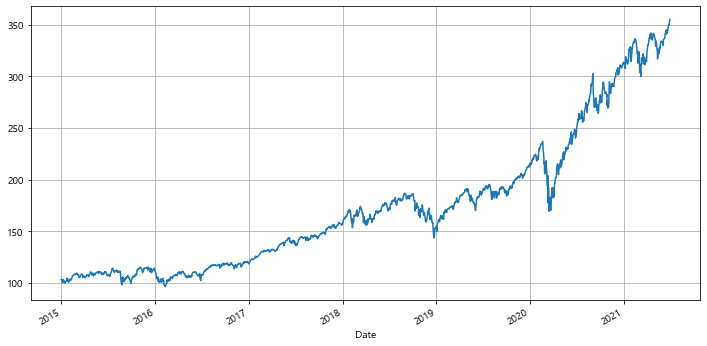

In [5]:
qqq.Close.plot(figsize=(12,6), grid=True)
plt.show()

## Prophet 사용

In [6]:
start = datetime(2015,1,1)
end = datetime(2021, 6, 30)
qqq = yf.download('QQQ',start=start, end=end)
qqq.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-06-23,347.510010,348.920013,346.880005,347.739990,347.739990,27188500
2021-06-24,349.730011,351.459991,349.170013,349.890015,349.890015,32581600
2021-06-25,350.470001,350.720001,348.839996,349.459991,349.459991,28682800
2021-06-28,350.779999,353.850006,350.720001,353.709991,353.709991,39130300
2021-06-29,353.529999,355.019989,352.670013,354.989990,354.989990,29426000


In [7]:
df = pd.DataFrame({
    'ds' : qqq.index, 'y': qqq.Close
})
df.head()

,ds,y
Date,,
2014-12-31,2014-12-31,103.250000
2015-01-02,2015-01-02,102.940002
2015-01-05,2015-01-05,101.430000
2015-01-06,2015-01-06,100.070000
2015-01-07,2015-01-07,101.360001


In [11]:
df.reset_index(inplace=True)
del df['Date']
df.tail()

,ds,y
1630,2021-06-23,347.739990
1631,2021-06-24,349.890015
1632,2021-06-25,349.459991
1633,2021-06-28,353.709991
1634,2021-06-29,354.989990


In [9]:
import pystan
model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
model = pystan.StanModel(model_code=model_code)  # this will take a minute
y = model.sampling(n_jobs=1).extract()['y']
y.mean()  # should be close to 0

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5944b02c79788fa0db5b3a93728ca2bf NOW.


0.03820753950011869

In [10]:
model = Prophet(daily_seasonality=True)
model.fit(df)

In [12]:
future = model.make_future_dataframe(184)
future.tail()

,ds
1814,2021-12-26
1815,2021-12-27
1816,2021-12-28
1817,2021-12-29
1818,2021-12-30


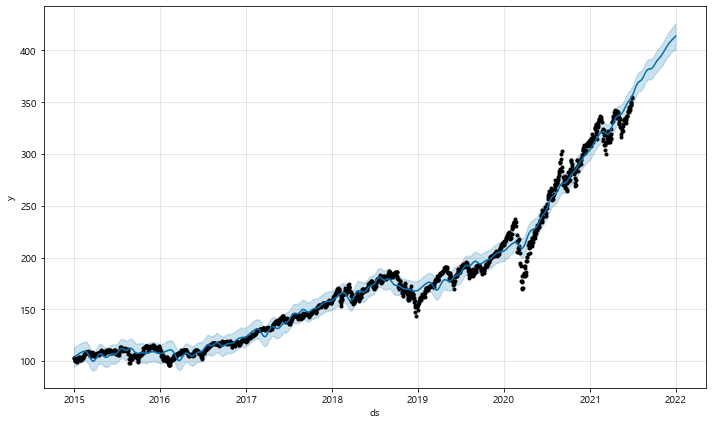

In [13]:
forecast = model.predict(future)
model.plot(forecast);

In [14]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-12-31,103.036491,94.670184,113.082364,103.036491,103.036491,1.307976,1.307976,1.307976,0.597463,...,0.096827,0.096827,0.096827,0.613686,0.613686,0.613686,0.0,0.0,0.0,104.344466
1,2015-01-02,103.146934,95.224190,113.822762,103.146934,103.146934,1.132629,1.132629,1.132629,0.597463,...,-0.086355,-0.086355,-0.086355,0.621521,0.621521,0.621521,0.0,0.0,0.0,104.279563
2,2015-01-05,103.312600,95.226342,113.463579,103.312600,103.312600,1.220316,1.220316,1.220316,0.597463,...,-0.099416,-0.099416,-0.099416,0.722269,0.722269,0.722269,0.0,0.0,0.0,104.532916
3,2015-01-06,103.367822,95.781917,114.193494,103.367822,103.367822,1.516414,1.516414,1.516414,0.597463,...,0.140584,0.140584,0.140584,0.778368,0.778368,0.778368,0.0,0.0,0.0,104.884236
4,2015-01-07,103.423044,96.426748,114.016387,103.423044,103.423044,1.538990,1.538990,1.538990,0.597463,...,0.096827,0.096827,0.096827,0.844701,0.844701,0.844701,0.0,0.0,0.0,104.962034


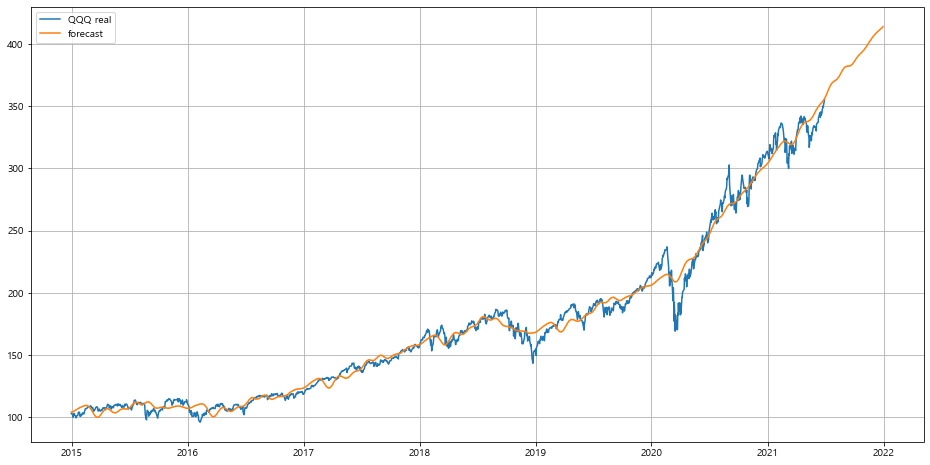

In [15]:
plt.figure(figsize=(16,8))
plt.plot(qqq.index, qqq.Close, label='QQQ real')
plt.plot(forecast.ds, forecast.yhat, label='forecast')
plt.grid()
plt.legend()
plt.show()